In [1]:
# Binary Classifier implementation (model architecture, training, testing, etc.) derived from
#     https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89

In [2]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tree import Tree
import numpy as np
import pickle
import random
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from stanfordcorenlp import StanfordCoreNLP
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
MAX_PHRASE_LEN = 6
VECTOR_SIZE = 200
WINDOW_SIZE = 5
NUM_LAYERS = 4

SHOULD_EXTRACT_NOUN_PHRASES = False
SHOULD_GENERATE_UNDERSCORED_CORPUS = False
SHOULD_TRAIN_WORD2VEC_MODEL = False

EPOCHS = 300
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [4]:
with open('data/arxiv_abstracts_10000.txt', 'r') as f:
    arxiv_abstracts = f.read().split('\n')[:-1]
    arxiv_abstracts_raw = '\n'.join(arxiv_abstracts)
    f.close()
print(f'Loaded {len(arxiv_abstracts)} arxiv abstracts.')

Loaded 10000 arxiv abstracts.


In [5]:
negative_samples = pickle.load(open('data/negative_samples.pkl', 'rb'))
print(f'Loaded {len(negative_samples)} negative samples.')

Loaded 1900 negative samples.


In [6]:
positive_samples = pickle.load(open('data/positive_samples.pkl', 'rb'))
print(f'Loaded {len(positive_samples)} positive samples.')

Loaded 1900 positive samples.


In [7]:
def extract_phrase(tree_str, label):
    phrases = []
    trees = Tree.fromstring(tree_str)
    for tree in trees:
        for subtree in tree.subtrees():
            if subtree.label() == label:
                t = subtree
                t = ' '.join(t.leaves())
                phrases.append(t)
    return phrases

In [8]:
if SHOULD_EXTRACT_NOUN_PHRASES:
    nlp = StanfordCoreNLP('data/stanford-corenlp-4.1.0')
    noun_phrases = []
    for i, abstract in enumerate(arxiv_abstracts):
        if (i + 1) % 10 == 0:
            print(f'Extracting noun phrases from abstract {i + 1} of {len(arxiv_abstracts)}')
            pickle.dump(noun_phrases, open('data/noun_phrases.pkl', 'wb'))
        try:
            tree_str = nlp.parse(abstract)
            noun_phrases.extend(extract_phrase(tree_str, 'NP'))
        except Exception:
            pass
    noun_phrases = [np for np in list(set(noun_phrases)) if len(np.split()) <= MAX_PHRASE_LEN]
    pickle.dump(noun_phrases, open('data/noun_phrases.pkl', 'wb'))
noun_phrases = pickle.load(open('data/noun_phrases.pkl', 'rb'))

In [9]:
def find_phrase_in_corpus(corpus, phrase):
    s_idx = corpus.find(phrase)
    e_idx = s_idx + len(phrase)
    if s_idx != -1 and \
       (s_idx == 0 or corpus[s_idx - 1] in (string.punctuation + ' ')) and \
       (e_idx == len(corpus) or corpus[e_idx] in (string.punctuation + ' ')):
        return (s_idx, e_idx)
    return (-1, -1)

In [10]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    corpus = arxiv_abstracts_raw[:]

In [11]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    for i, positive_sample in enumerate(positive_samples):
        if (i + 1) % 100 == 0:
            print(f'Replacing positive_sample {i + 1} of {len(positive_samples)}')
        found_indices = set()
        while find_phrase_in_corpus(corpus, positive_sample) != (-1, -1) and find_phrase_in_corpus(corpus, positive_sample)[0] not in found_indices:
            s_idx, e_idx = find_phrase_in_corpus(corpus, positive_sample)
            found_indices.add(s_idx)
            corpus = corpus[:s_idx] + positive_sample.replace(' ', '_') + corpus[e_idx:]

In [12]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    for i, negative_sample in enumerate(negative_samples):
        if (i + 1) % 100 == 0:
            print(f'Replacing negative_sample {i + 1} of {len(negative_samples)}')
        found_indices = set()
        while find_phrase_in_corpus(corpus, negative_sample) != (-1, -1) and find_phrase_in_corpus(corpus, negative_sample)[0] not in found_indices:
            s_idx, e_idx = find_phrase_in_corpus(corpus, negative_sample)
            found_indices.add(s_idx)
            corpus = corpus[:s_idx] + negative_sample.replace(' ', '_') + corpus[e_idx:]

In [13]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    for i, noun_phrase in enumerate(noun_phrases):
        if (i + 1) % 100 == 0:
            print(f'Replacing noun_phrase {i + 1} of {len(noun_phrases)}')
        found_indices = set()
        while find_phrase_in_corpus(corpus, noun_phrase) != (-1, -1) and find_phrase_in_corpus(corpus, noun_phrase)[0] not in found_indices:
            s_idx, e_idx = find_phrase_in_corpus(corpus, noun_phrase)
            found_indices.add(s_idx)
            corpus = corpus[:s_idx] + noun_phrase.replace(' ', '_') + corpus[e_idx:]

In [14]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    pickle.dump(corpus, open('data/underscored_corpus.pkl', 'wb'))

In [15]:
underscored_corpus = pickle.load(open('data/underscored_corpus.pkl', 'rb'))

In [16]:
if SHOULD_TRAIN_WORD2VEC_MODEL:
    underscored_corpus_data = []
    for i in sent_tokenize(underscored_corpus):
        temp = []
        for j in word_tokenize(i):
            temp.append(j.lower())
        underscored_corpus_data.append(temp)

In [17]:
if SHOULD_TRAIN_WORD2VEC_MODEL:
    word2vec_model = Word2Vec(underscored_corpus_data, min_count=1, window=WINDOW_SIZE, size=VECTOR_SIZE)
    word2vec_model.save(f'data/word2vec_model_vs_{VECTOR_SIZE}_ws_{WINDOW_SIZE}')

In [18]:
word2vec_model = Word2Vec.load(f'data/word2vec_model_vs_{VECTOR_SIZE}_ws_{WINDOW_SIZE}')

In [19]:
tokens = [token for token in list(word2vec_model.wv.vocab.keys())]
embeddings = {token: word2vec_model.wv[token] for token in tokens}

In [20]:
positive_samples = [ps for ps in positive_samples if ps.replace(' ', '_') in embeddings]
negative_samples = [ns for ns in negative_samples if ns.replace(' ', '_') in embeddings]
noun_phrases = [np for np in noun_phrases if np.replace(' ', '_') in embeddings]

In [21]:
X = []
y = []
for phrase in positive_samples:
    X.append(embeddings[phrase.replace(' ', '_')])
    y.append(1)
for phrase in negative_samples:
    X.append(embeddings[phrase.replace(' ', '_')])
    y.append(0)

In [22]:
c = list(zip(X, y))
random.shuffle(c)
X, y = zip(*c)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()

        self.layer_1 = nn.Linear(VECTOR_SIZE, 128)
        
        self.layers = []
        for _ in range(NUM_LAYERS - 1):
            self.layers.append(nn.Linear(128, 128))
        
        self.layer_out = nn.Linear(128, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        
        for layer in self.layers:
            x = self.relu(layer(x))

        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BinaryClassifier()
model.to(device)

BinaryClassifier(
  (layer_1): Linear(in_features=200, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [26]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [27]:
class TrainDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_data = TrainDataset(torch.FloatTensor(np.array(X_train, dtype=np.float64)), 
                          torch.FloatTensor(y_train))

In [28]:
class TestDataset(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestDataset(torch.FloatTensor(np.array(X_test, dtype=np.float64)))

In [29]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [30]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [31]:
epoch_losses = []
for e in range(1, EPOCHS + 1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    epoch_losses.append(epoch_loss / len(train_loader)) 

    if e % 10 == 0:
        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 010: | Loss: 0.57302 | Acc: 72.818
Epoch 020: | Loss: 0.52349 | Acc: 74.705
Epoch 030: | Loss: 0.49546 | Acc: 76.023
Epoch 040: | Loss: 0.47814 | Acc: 76.932
Epoch 050: | Loss: 0.46577 | Acc: 77.341
Epoch 060: | Loss: 0.45460 | Acc: 77.682
Epoch 070: | Loss: 0.44562 | Acc: 77.705
Epoch 080: | Loss: 0.43820 | Acc: 77.977
Epoch 090: | Loss: 0.43470 | Acc: 78.682
Epoch 100: | Loss: 0.42657 | Acc: 78.568
Epoch 110: | Loss: 0.42005 | Acc: 79.455
Epoch 120: | Loss: 0.41993 | Acc: 79.023
Epoch 130: | Loss: 0.41336 | Acc: 79.682
Epoch 140: | Loss: 0.40707 | Acc: 79.977
Epoch 150: | Loss: 0.40556 | Acc: 80.045
Epoch 160: | Loss: 0.40165 | Acc: 80.364
Epoch 170: | Loss: 0.39687 | Acc: 80.818
Epoch 180: | Loss: 0.38971 | Acc: 80.977
Epoch 190: | Loss: 0.39007 | Acc: 81.114
Epoch 200: | Loss: 0.38232 | Acc: 81.614
Epoch 210: | Loss: 0.37938 | Acc: 81.477
Epoch 220: | Loss: 0.37748 | Acc: 81.432
Epoch 230: | Loss: 0.37226 | Acc: 81.545
Epoch 240: | Loss: 0.36870 | Acc: 82.000
Epoch 250: | Los

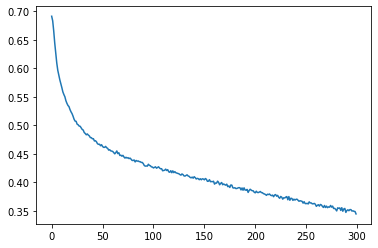

In [32]:
plt.plot(epoch_losses)

In [33]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [34]:
print(confusion_matrix(y_test, y_pred_list))
print(classification_report(y_test, y_pred_list))

[[252  84]
 [114 247]]
              precision    recall  f1-score   support

           0       0.69      0.75      0.72       336
           1       0.75      0.68      0.71       361

    accuracy                           0.72       697
   macro avg       0.72      0.72      0.72       697
weighted avg       0.72      0.72      0.72       697



In [35]:
test_samples = random.sample(noun_phrases, 10000)
X_samples = []
for sample in test_samples:
    X_samples.append(embeddings[sample.replace(' ', '_')])
sample_data = TestDataset(torch.FloatTensor(np.array(X_samples, dtype=np.float64)))
sample_loader = DataLoader(dataset=sample_data, batch_size=1)

extracted = []
not_extracted = []
model.eval()
with torch.no_grad():
    for i, X_batch in enumerate(sample_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        if y_pred_tag.cpu().numpy()[0][0] == 1:
            extracted.append(test_samples[i])
        else:
            not_extracted.append(test_samples[i])

In [36]:
extracted

['feature',
 'the laboratory',
 'sufficient training data and fully annotated training data',
 'nonlinearities',
 'randomized least squares',
 'policy space',
 'the fields',
 'a new loss function',
 'parallelization',
 'a greedy method',
 'camera',
 'quantization',
 'inferences',
 'static neurons',
 'multi relational data',
 'the search',
 'momentum',
 'loss surfaces',
 'the shortcomings',
 'accurate prediction',
 'social choice theory',
 'identity',
 'expert knowledge',
 'varying quality',
 'concern',
 'the help',
 'sa',
 'a problem',
 'artificial life',
 'our predilection',
 'population',
 'their power',
 'the appearance',
 'different distributions',
 'millions of parameters',
 'background',
 'general purpose vector representation of tweets',
 'hyperparameters',
 'instructions',
 'the shift',
 'memory cells',
 'artificial agents',
 'patient notes',
 'translations and rotations',
 'the weaknesses',
 'mikolov',
 'membership',
 'hardware',
 'the bayesian model',
 'abnormalities',
 'sutt

In [37]:
not_extracted

['dr',
 'a globally normalized transition based neural network model that achieves state of the art part of speech tagging dependency parsing and sentence compression results',
 'episodic mdps',
 'incremental network quantization inq',
 'data that are characterized by relational structures',
 'data sparsity',
 'every day',
 'the markov network structure',
 'the missing',
 'translated output in desired form',
 'human brain function',
 'convolutional neural network tbcnn for discriminative sentence modeling',
 'da',
 'question answering and dialog systems',
 'a small perturbation to an input',
 'a multi modal embedding of visual and natural language data',
 'new complexity results',
 'joint distributions',
 'the gains in precision and speed',
 'computational epigraphy',
 'the memory',
 'the problem of learning a task from demonstration',
 'topic models with a logistic likelihood',
 'persistent contrastive divergence pcd',
 'the leading approaches',
 'liquidsvm',
 'missing relationships l